# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [9]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [10]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 16, 16, 44, 8, 94484)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [11]:
# os.environ["HOPSWORKS_API_KEY"] = ""

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1160344
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [12]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [13]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [14]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='4.581654E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float'], gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [15]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
today_timestamp = pd.to_datetime(today)
batch_data = weather_fg.filter(weather_fg.date >= today_timestamp ).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.68s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-21 00:00:00+00:00,21.549999,0.0,6.763786,64.798920,lahore
1,2024-11-20 00:00:00+00:00,21.150000,0.0,1.800000,323.130005,lahore
2,2024-11-17 00:00:00+00:00,21.900000,0.0,4.802999,282.994629,lahore
3,2024-11-22 00:00:00+00:00,22.799999,0.0,5.483356,66.801384,lahore
4,2024-11-25 00:00:00+00:00,20.600000,0.0,5.400000,323.130035,lahore
5,2024-11-24 00:00:00+00:00,22.200001,0.0,7.594207,5.440250,lahore
6,2024-11-19 00:00:00+00:00,21.200001,0.0,6.924738,278.972534,lahore
7,2024-11-23 00:00:00+00:00,22.299999,0.0,6.151683,20.556128,lahore
8,2024-11-18 00:00:00+00:00,21.400000,0.0,5.411986,273.813995,lahore


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [16]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25
0,2024-11-21 00:00:00+00:00,21.549999,0.0,6.763786,64.798920,lahore,88.809822
1,2024-11-20 00:00:00+00:00,21.150000,0.0,1.800000,323.130005,lahore,110.297066
2,2024-11-17 00:00:00+00:00,21.900000,0.0,4.802999,282.994629,lahore,69.217422
3,2024-11-22 00:00:00+00:00,22.799999,0.0,5.483356,66.801384,lahore,113.785210
4,2024-11-25 00:00:00+00:00,20.600000,0.0,5.400000,323.130035,lahore,107.641327
5,2024-11-24 00:00:00+00:00,22.200001,0.0,7.594207,5.440250,lahore,28.395956
6,2024-11-19 00:00:00+00:00,21.200001,0.0,6.924738,278.972534,lahore,39.269863
7,2024-11-23 00:00:00+00:00,22.299999,0.0,6.151683,20.556128,lahore,34.799728
8,2024-11-18 00:00:00+00:00,21.400000,0.0,5.411986,273.813995,lahore,87.573425


In [17]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   predicted_pm25               9 non-null      float32            
dtypes: datetime64[us, UTC](1), float32(5), object(1)
memory usage: 452.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [18]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data['date'] = batch_data['date'].dt.tz_convert(None).astype('datetime64[ns]')
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
2,2024-11-17,21.900000,0.0,4.802999,282.994629,lahore,69.217422,pakistan-lahore-cantonment,pakistan,3
8,2024-11-18,21.400000,0.0,5.411986,273.813995,lahore,87.573425,pakistan-lahore-cantonment,pakistan,9
6,2024-11-19,21.200001,0.0,6.924738,278.972534,lahore,39.269863,pakistan-lahore-cantonment,pakistan,7
1,2024-11-20,21.150000,0.0,1.800000,323.130005,lahore,110.297066,pakistan-lahore-cantonment,pakistan,2
0,2024-11-21,21.549999,0.0,6.763786,64.798920,lahore,88.809822,pakistan-lahore-cantonment,pakistan,1
3,2024-11-22,22.799999,0.0,5.483356,66.801384,lahore,113.785210,pakistan-lahore-cantonment,pakistan,4
7,2024-11-23,22.299999,0.0,6.151683,20.556128,lahore,34.799728,pakistan-lahore-cantonment,pakistan,8
5,2024-11-24,22.200001,0.0,7.594207,5.440250,lahore,28.395956,pakistan-lahore-cantonment,pakistan,6
4,2024-11-25,20.600000,0.0,5.400000,323.130035,lahore,107.641327,pakistan-lahore-cantonment,pakistan,5


In [19]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2 to 4
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         9 non-null      datetime64[ns]
 1   temperature_2m_mean          9 non-null      float32       
 2   precipitation_sum            9 non-null      float32       
 3   wind_speed_10m_max           9 non-null      float32       
 4   wind_direction_10m_dominant  9 non-null      float32       
 5   city                         9 non-null      object        
 6   predicted_pm25               9 non-null      float32       
 7   street                       9 non-null      object        
 8   country                      9 non-null      object        
 9   days_before_forecast_day     9 non-null      int64         
dtypes: datetime64[ns](1), float32(5), int64(1), object(3)
memory usage: 612.0+ bytes


### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2024-11-16 16:44:19,210 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



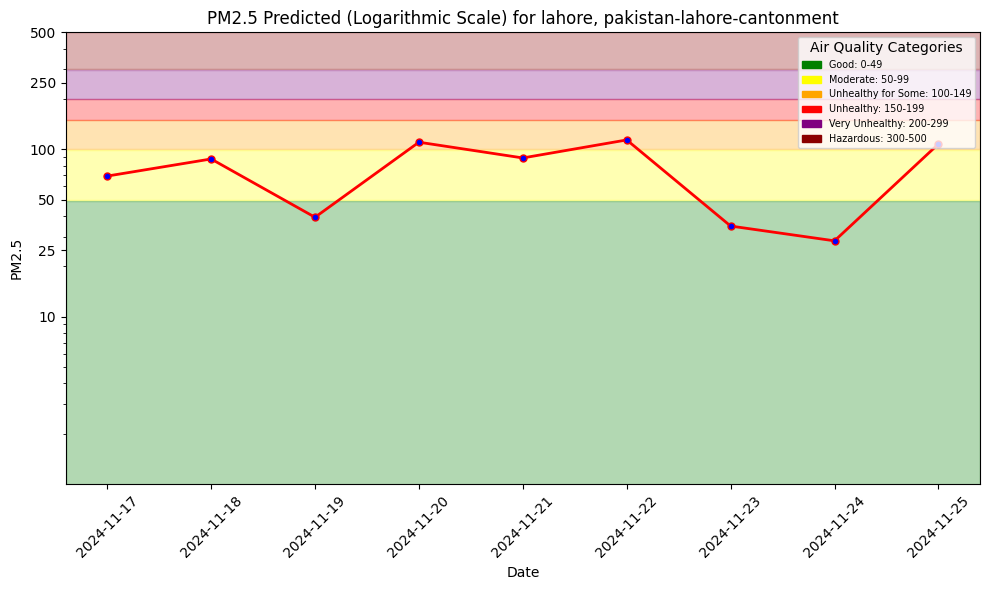

In [20]:
file_path = "../../docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [21]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [22]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1160344/fs/1151047/fg/1349980


Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1160344/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7fb739407070>, None)

In [23]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.69s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-21 00:00:00+00:00,21.549999,0.0,6.763786,64.79892,lahore,88.809822,pakistan-lahore-cantonment,pakistan,1


In [24]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.08s) 


,date,pm25,country,city,street,url
0,2020-06-17,22.120001,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005
1,2022-09-03,8.350000,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005
2,2024-09-21,16.750000,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005
3,2023-12-12,106.650002,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005
4,2022-04-30,33.599998,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005
...,...,...,...,...,...,...
1783,2020-03-29,16.600000,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005
1784,2022-01-25,73.930000,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005
1785,2022-02-02,45.869999,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005
1786,2021-05-31,8.250000,pakistan,lahore,pakistan-lahore-cantonment,https://api.waqi.info/feed/A74005


In [25]:
air_quality_df['date']

0       2020-06-17
1       2022-09-03
2       2024-09-21
3       2023-12-12
4       2022-04-30
           ...    
1783    2020-03-29
1784    2022-01-25
1785    2022-02-02
1786    2021-05-31
1787    2024-11-16
Name: date, Length: 1788, dtype: object

In [26]:
monitoring_df['date']

0   2024-11-21 00:00:00+00:00
Name: date, dtype: datetime64[us, UTC]

In [27]:
air_quality_df['date'] = pd.to_datetime(air_quality_df['date'])
monitoring_df['date'] = monitoring_df['date'].dt.tz_convert(None).astype('datetime64[ns]')

In [28]:


outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.94s) 


Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1160344/jobs/named/aq_predictions_1_offline_fg_materialization/executions


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,predicted_pm25,pm25,street,country,days_before_forecast_day
0,2024-11-16,21.700001,0.0,2.595997,33.690102,lahore,82.219673,182.0,pakistan-lahore-cantonment,pakistan,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

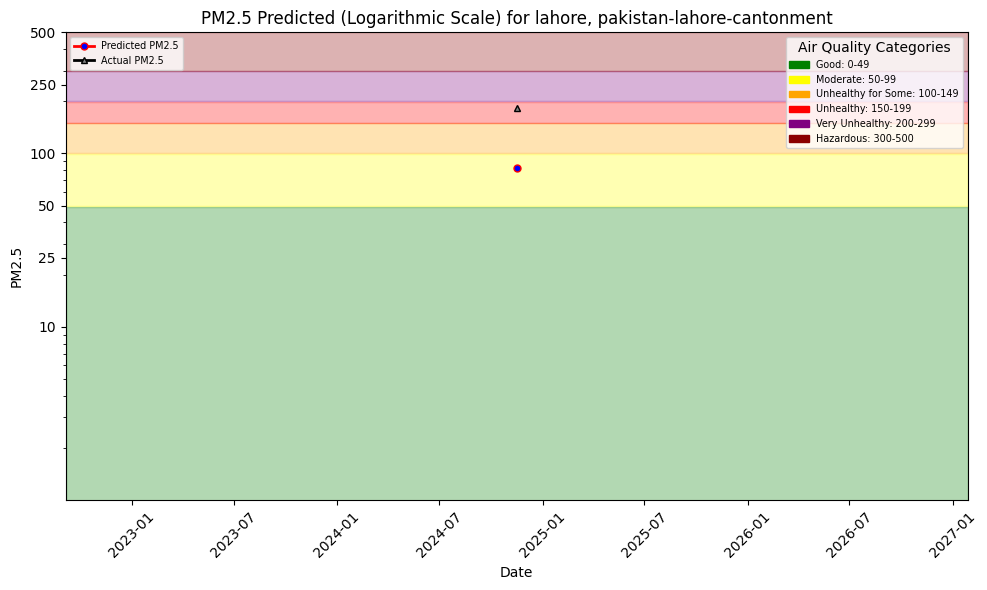

In [29]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

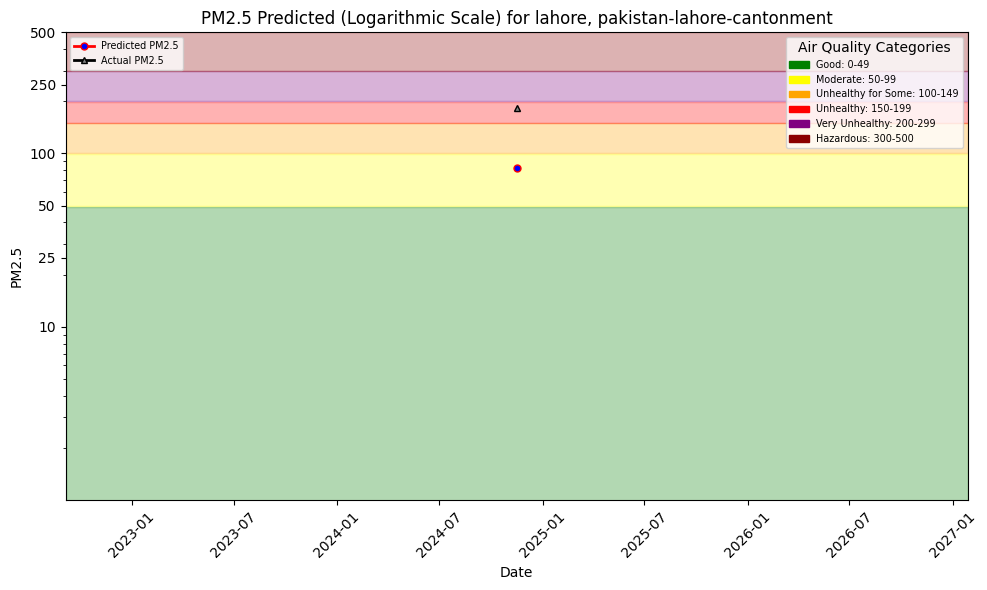

In [30]:
file_path = "../../docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---